In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import math
import random
from keras.models import Sequential,Model
from keras.layers import TimeDistributed,Dense,Activation,Layer,Input,Average,Concatenate,Flatten,Lambda
from keras.optimizers import Adam
import pylab as pl
from IPython import display
import numpy as np
import csv
import data_format

In [2]:
def csv_to_array(csv_file_name):
    data = []
    flag = True
    with open(csv_file_name, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            if(flag):
                flag = False
                continue
            data.append(row)
    
    data = np.array(data)

In [3]:
d_N = 1
n_max=1 # maximum number of observations that can be used during the training process
a,b,c,d = data_format.data_per_trajectory('C:/Users/dmtya/Cappuccino-Preparing-Robot-Baxter/carry_data/train1', True)
train_joints = np.array(a)[:, :8, :] #for left arm
train_n = np.array(b)
train_t = np.array(c)  
train_p = np.array(d)

C:\Users\dmtya\Cappuccino-Preparing-Robot-Baxter\Task Parameterization and Generalization\data_format.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data), max_size


In [13]:
train_n

array([3866, 3866])

In [5]:
train_p

array([[0.57734376, 0.80859375],
       [0.57734376, 0.80859375]], dtype=float32)

In [6]:
train_joints.shape

(2, 8, 3866)

In [7]:
train_joints[:, :8, :]

array([[[-2.68446631e-03, -5.46864152e-01,  3.06796166e-03, ...,
          9.56239853e+01,  4.60194238e-03, -5.48398137e-01],
        [-1.91747595e-03,  7.53568053e-01,  2.30097119e-03, ...,
         -5.47631145e-01,  2.68446631e-03,  7.52801061e-01],
        [-3.06796166e-03,  1.25556326e+00,  1.53398083e-03, ...,
          1.95659244e+00, -1.34223318e-02, -1.25786424e-01],
        ...,
        [ 3.06796166e-03,  7.53951550e-01, -2.68446631e-03, ...,
         -2.04402938e-01, -1.02009721e-01,  1.17924774e+00],
        [-1.25019431e-01, -4.81286466e-01,  1.20033994e-01, ...,
          7.52801061e-01, -2.68446631e-03,  1.25479627e+00],
        [ 1.91747595e-03,  9.56239853e+01,  8.89325380e-01, ...,
         -4.00368989e-01,  1.20417491e-01,  9.56168823e+01]],

       [[-3.06796166e-03, -5.46480656e-01,  2.30097119e-03, ...,
          9.56239853e+01,  3.83495190e-03, -5.39961219e-01],
        [-4.60194238e-03,  7.71975815e-01,  1.15048559e-03, ...,
         -5.46097159e-01,  1.91747595e

In [8]:
def get_train_sample():
    observation = np.zeros((1,n_max,11))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,3)) # t, ob_p, w_p  
    gamma = random.randint(0,d_N-1)
    ob_p = train_p[gamma,0]
    w_p = train_p[gamma,1]
    obs_n = random.randint(1,n_max)
    
    perm = np.random.permutation(train_n[gamma])
    
    for i in range(obs_n):
        observation[0,i] = [train_t[gamma,perm[i]],
                            ob_p, # 0,1,2 -> 1/3,2/3,1
                            w_p, # 0,1,2,3 -> 1/4,2/4,3/4,1
                            train_joints[gamma,0,perm[i]],
                            train_joints[gamma,1,perm[i]],
                            train_joints[gamma,2,perm[i]],
                            train_joints[gamma,3,perm[i]],
                            train_joints[gamma,4,perm[i]],
                            train_joints[gamma,5,perm[i]],
                            train_joints[gamma,6,perm[i]],
                            train_joints[gamma,7,perm[i]]
                           ]
        observation_flag[0,0,i] = 1./obs_n
    target[0,0] = [train_t[gamma,perm[obs_n]], ob_p, w_p]
    return [observation,observation_flag,target], \
            [[[[train_joints[gamma,0,perm[obs_n]],
                train_joints[gamma,1,perm[obs_n]],
                train_joints[gamma,2,perm[obs_n]],
                train_joints[gamma,3,perm[obs_n]],
                train_joints[gamma,4,perm[obs_n]],
                train_joints[gamma,5,perm[obs_n]],
                train_joints[gamma,6,perm[obs_n]],
                train_joints[gamma,7,perm[obs_n]]
                ]]]],gamma

In [9]:
def plt_predictions(gamma=1): 
    ob_p=train_p[gamma,0]
    w_p=train_p[gamma,1]
    prediction = np.zeros((8,train_n[gamma]))
    prediction_std = np.zeros((8,train_n[gamma])) #TODO: 6?
    observation = np.zeros((1,n_max,11))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,3))
    observation[0,0] = [0,ob_p,w_p,
                        train_joints[gamma,0,0],
                        train_joints[gamma,1,0],
                        train_joints[gamma,2,0],
                        train_joints[gamma,3,0],
                        train_joints[gamma,4,0],
                        train_joints[gamma,5,0],
                        train_joints[gamma,6,0],
                        train_joints[gamma,7,0]]
    observation_flag[0,0,0] = 1.
    joint_names = ['a','b','c','d','e','f','g','h']        
    for i in range(train_n[gamma]):
        target[0,0] = [train_t[gamma,i],ob_p,w_p]
        p = model.predict([observation,observation_flag,target])[0][0]
        prediction[:,i] = p[:8]
        for j in range(8):
            prediction_std[j,i] = math.log(1+math.exp(p[j]))#TODO: dont understand here. did I do right?
    for joint in range(8):
        fig = plt.figure(figsize=(5,5))
        plt.title(joint_names[joint])
        # if joint == 4:
        #     plt.ylim(-1.35,-1.75)
        for i in range(d_N):
            plt.plot(range(train_n[i]),train_joints[i,joint,:train_n[i]])
        plt.plot(range(train_n[gamma]),prediction[joint,:train_n[gamma]],color='red')
        plt.errorbar(range(train_n[gamma]),prediction[joint,:train_n[gamma]],yerr=prediction_std[2,:train_n[gamma]],color = 'red',alpha=0.1)
        plt.show()

In [10]:
def custom_loss(y_true, y_pred):
    mean, log_sigma = tf.split(y_pred, 2, axis=-1)
    y_target, temp =tf.split(y_true,2,axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_target))
    return loss

In [11]:
observation_layer = Input(shape=(n_max,11))
observation_flag_layer=Input(shape=(1,n_max)) 
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_layer)
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(128))(observation_encoded)
matmul_layer=Lambda(lambda x:(tf.matmul(x[0],x[1])), output_shape =(1,128))
representation=matmul_layer([observation_flag_layer,observation_encoded])
target_layer = Input(shape=(1,3))
query_net_input = Concatenate(axis=2)([representation, target_layer])
query = Dense(128, activation='relu')(query_net_input)
query = Dense(128, activation='relu')(query)
query = Dense(128, activation='relu')(query)
query = Dense(128, activation='relu')(query)
output_layer = Dense(8)(query)
model = Model(inputs=[observation_layer,observation_flag_layer,target_layer],outputs=output_layer)
model.compile(optimizer = Adam(lr = 1e-4),loss=custom_loss)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 11)]      0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 1, 128)      1536        ['input_1[0][0]']                
 ted)                                                                                             
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 1, 128)      16512       ['time_distributed[0][0]']       
 buted)                                                                                           
                                                                                              

c:\users\dmtya\appdata\local\programs\python\python37\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


<Figure size 640x480 with 0 Axes>

step: 0
loss: 9543.0576171875


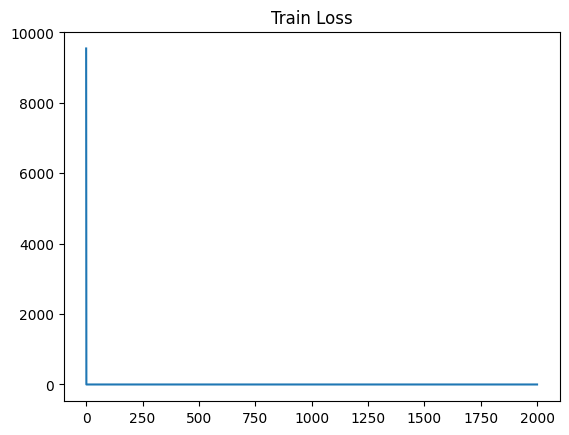

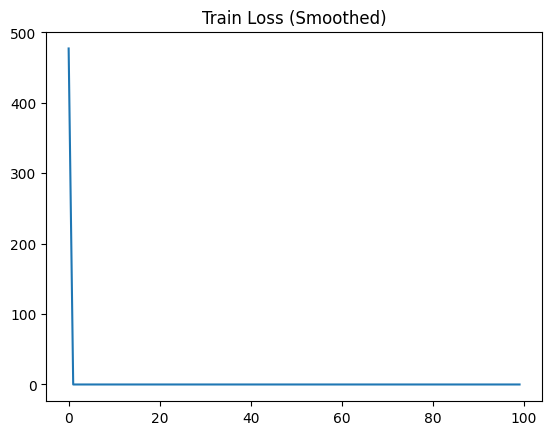

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


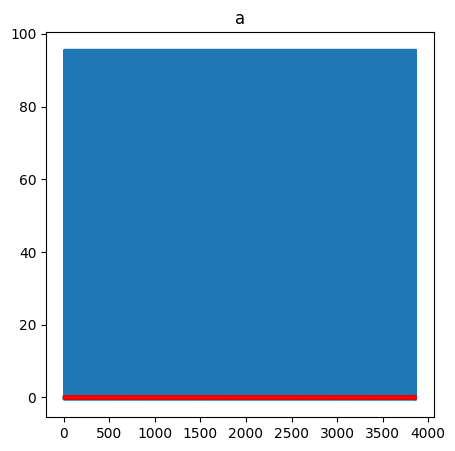

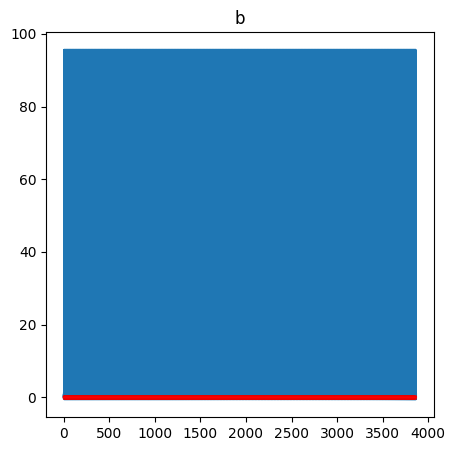

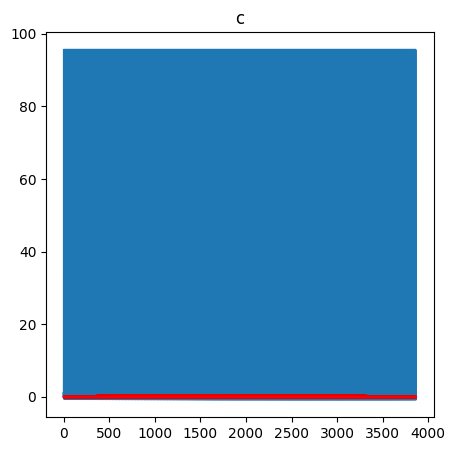

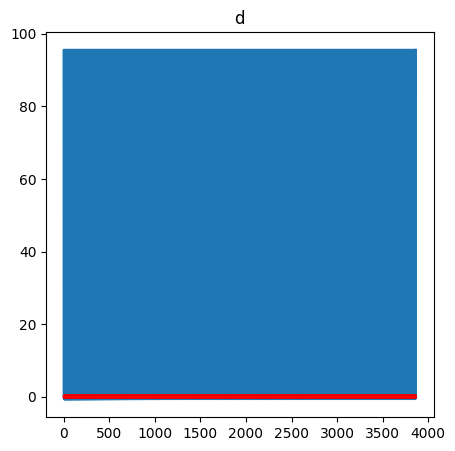

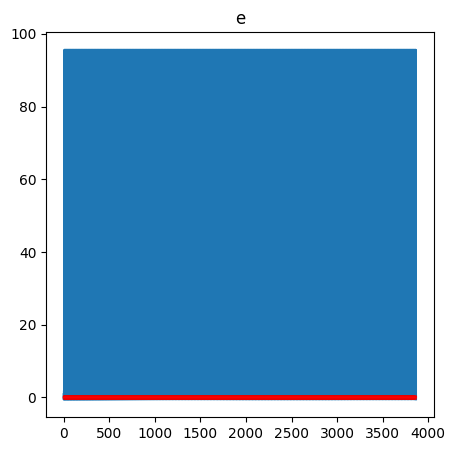

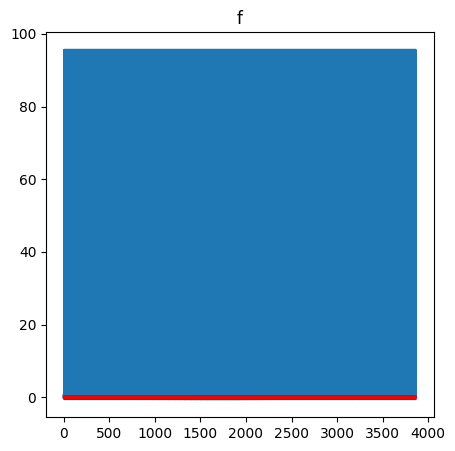

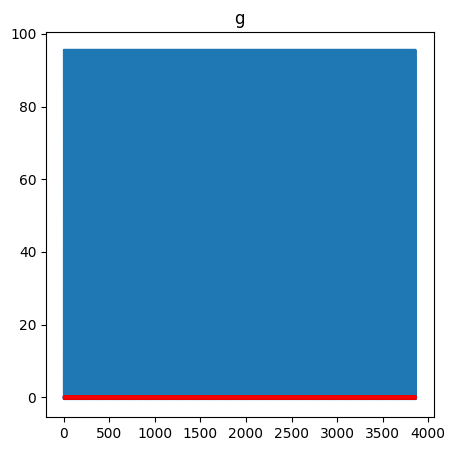

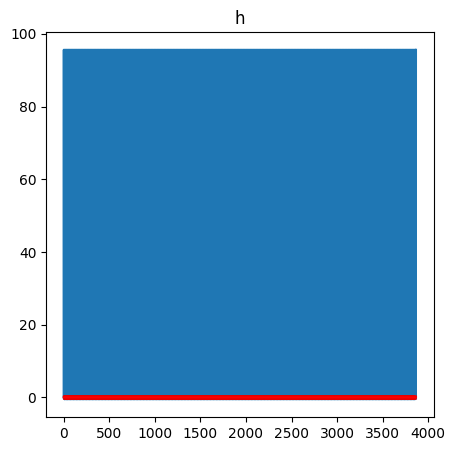

In [12]:
train_loss = np.zeros(2000)
max_iterations=10000
for step in range(max_iterations):
    inp,out,gamma = get_train_sample()
    out = np.array(out)
    data = model.fit(inp,out,batch_size=1,verbose=0)

    if step % 1000 == 0:
        train_loss[step//1000] = data.history['loss'][0]
    if step % 10000 == 0:
        display.clear_output(wait=True)
        display.display(pl.gcf())
        print( 'step:', step)
        print( 'loss:', data.history['loss'][0])
        plt.title('Train Loss')
        plt.plot(range(2000),train_loss)
        plt.show()
        mean_loss = np.zeros((100))
        for i in range(100):
            mean_loss[i] = np.mean(train_loss[i*20:(i+1)*20])
        fig = plt.figure()
        plt.title('Train Loss (Smoothed)')
        plt.plot(range(100),mean_loss)
        plt.show()
        plt_predictions(0)